In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, year, sum as spark_sum, max as spark_max

spark = SparkSession.builder.appName("Analisa Penjualan").getOrCreate()

data = [
    ("P001", "Produk A", "Elektronik", 10, 200, "2022-01-10"),
    ("P002", "Produk B", "Elektronik", 30, 150, "2022-02-21"),
    ("P003", "Produk C", "Pakaian", 20, 100, "2022-03-12"),
    ("P004", "Produk D", "Pakaian", 15, 120, "2022-02-12"),
    ("P005", "Produk E", "Dapur", 25, 90, "2022-04-13"),
    ("P006", "Produk F", "Dapur", 5, 300, "2022-01-14")
]

kolom = ["ProductID", "ProductName", "Category", "Quantity", "Price", "Date"]
df = spark.createDataFrame(data, kolom)

df = df.withColumn("Date", col("Date").cast("date"))

df.show()

+---------+-----------+----------+--------+-----+----------+
|ProductID|ProductName|  Category|Quantity|Price|      Date|
+---------+-----------+----------+--------+-----+----------+
|     P001|   Produk A|Elektronik|      10|  200|2022-01-10|
|     P002|   Produk B|Elektronik|      30|  150|2022-02-21|
|     P003|   Produk C|   Pakaian|      20|  100|2022-03-12|
|     P004|   Produk D|   Pakaian|      15|  120|2022-02-12|
|     P005|   Produk E|     Dapur|      25|   90|2022-04-13|
|     P006|   Produk F|     Dapur|       5|  300|2022-01-14|
+---------+-----------+----------+--------+-----+----------+



In [7]:
df = df.withColumn("Month", month(col("Date"))).withColumn("Year", year(col("Date")))

df = df.withColumn("Revenue", col("Quantity") * col("Price"))

pendapatan_per_kategori = df.groupBy("Category", "Year", "Month").agg(spark_sum("Revenue").alias("TotalRevenue"))

pendapatan_per_kategori.show()

+----------+----+-----+------------+
|  Category|Year|Month|TotalRevenue|
+----------+----+-----+------------+
|Elektronik|2022|    2|        4500|
|Elektronik|2022|    1|        2000|
|   Pakaian|2022|    3|        2000|
|     Dapur|2022|    1|        1500|
|   Pakaian|2022|    2|        1800|
|     Dapur|2022|    4|        2250|
+----------+----+-----+------------+



In [11]:
harga_tertinggi_per_kategori = df.groupBy("Category").agg(spark_max("Price").alias("MaxPrice"))

df_alias = df.alias("df")
harga_tertinggi_alias = harga_tertinggi_per_kategori.alias("htk")

produk_harga_tertinggi = harga_tertinggi_alias.join(df_alias, 
    (harga_tertinggi_alias["Category"] == df_alias["Category"]) & 
    (harga_tertinggi_alias["MaxPrice"] == df_alias["Price"])) \
    .select("df.Category", "df.ProductName", "htk.MaxPrice")

produk_harga_tertinggi.show()

+----------+-----------+--------+
|  Category|ProductName|MaxPrice|
+----------+-----------+--------+
|Elektronik|   Produk A|     200|
|   Pakaian|   Produk D|     120|
|     Dapur|   Produk F|     300|
+----------+-----------+--------+



In [12]:
tren_penjualan_bulanan = df.groupBy("Year", "Month").agg(spark_sum("Revenue").alias("TotalRevenue"))

tren_penjualan_bulanan.show()

+----+-----+------------+
|Year|Month|TotalRevenue|
+----+-----+------------+
|2022|    2|        6300|
|2022|    3|        2000|
|2022|    1|        3500|
|2022|    4|        2250|
+----+-----+------------+



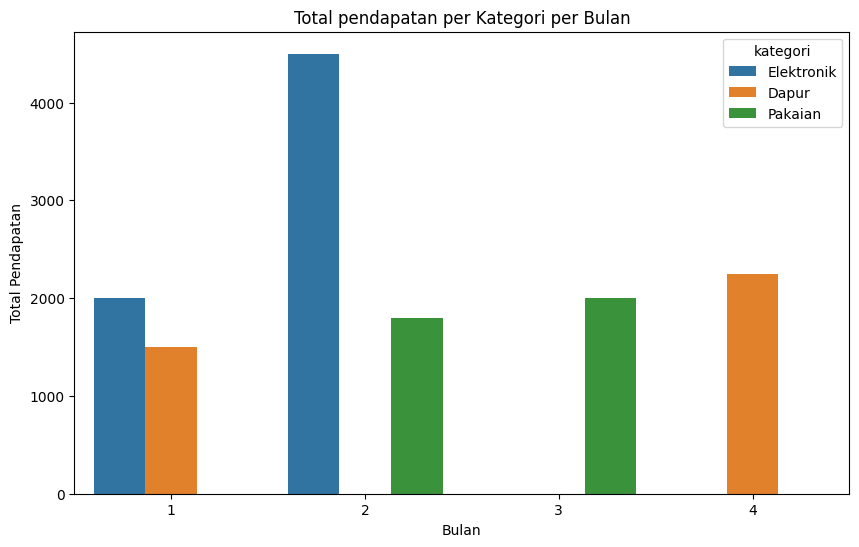

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

pendapatan_kategori_pd = pendapatan_per_kategori.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="Month", y="TotalRevenue", hue="Category", data=pendapatan_kategori_pd)
plt.title("Total pendapatan per Kategori per Bulan")
plt.xlabel("Bulan")
plt.ylabel("Total Pendapatan")
plt.legend(title="kategori")
plt.show()